In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

#Torch-related imports
import torch
import torch.distributions as D
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function
from TruncatedNormal import *

In [22]:
torch.manual_seed(0)
np.random.seed(0)

torch.set_printoptions(precision = 8)

In [37]:
temp_ref = 283
temp_rise = 5 #High estimate of 5 celsius temperature rise by 2100.

error_scale = 0.25

#SCON theta truncated normal distribution parameters in order of mean, sdev, lower, and upper.
u_M_dist = torch.Tensor([0.001, 0.001 * error_scale, 0, 0.01])
a_SD_dist = torch.Tensor([0.5, 0.5 * error_scale, 0, 1])
a_DS_dist = torch.Tensor([0.5, 0.5 * error_scale, 0, 1])
a_M_dist = torch.Tensor([0.5, 0.5 * error_scale, 0, 1])
a_MSC_dist = torch.Tensor([0.5, 0.5 * error_scale, 0, 1])
k_S_ref_dist = torch.Tensor([0.0002, 0.0002 * error_scale, 0, 0.001])
k_D_ref_dist = torch.Tensor([0.0008, 0.0008 * error_scale, 0, 0.001])
k_M_ref_dist = torch.Tensor([0.0003, 0.0003 * error_scale, 0, 0.001])
Ea_S_dist = torch.Tensor([55, 55 * error_scale, 20, 120])
Ea_D_dist = torch.Tensor([48, 48 * error_scale, 20, 120])
Ea_M_dist = torch.Tensor([48, 48 * error_scale, 20, 120])

#SCON-C diffusion matrix thetas
c_SOC_dist = torch.Tensor([0.05, 0.05 * error_scale, 0, 0.1])
c_DOC_dist = torch.Tensor([0.001, 0.001 * error_scale, 0, 0.01])
c_MBC_dist = torch.Tensor([0.001, 0.001 * error_scale, 0, 0.01])

#SCON-C theta rsample draws
u_M = TruncatedNormal(loc = u_M_dist[0], scale = u_M_dist[1], a = u_M_dist[2], b = u_M_dist[3]).rsample().cpu().detach().numpy()
a_SD = TruncatedNormal(loc = a_SD_dist[0], scale = a_SD_dist[1], a = a_SD_dist[2], b = a_SD_dist[3]).rsample().cpu().detach().numpy()
a_DS = TruncatedNormal(loc = a_DS_dist[0], scale = a_DS_dist[1], a = a_DS_dist[2], b = a_DS_dist[3]).rsample().cpu().detach().numpy()
a_M = TruncatedNormal(loc = a_M_dist[0], scale = a_M_dist[1], a = a_M_dist[2], b = a_M_dist[3]).rsample().cpu().detach().numpy()
a_MSC = TruncatedNormal(loc = a_MSC_dist[0], scale = a_MSC_dist[1], a = a_MSC_dist[2], b = a_MSC_dist[3]).rsample().cpu().detach().numpy()
k_S_ref = TruncatedNormal(loc = k_S_ref_dist[0], scale = k_S_ref_dist[1], a = k_S_ref_dist[2], b = k_S_ref_dist[3]).rsample().cpu().detach().numpy()
k_D_ref = TruncatedNormal(loc = k_D_ref_dist[0], scale = k_D_ref_dist[1], a = k_D_ref_dist[2], b = k_D_ref_dist[3]).rsample().cpu().detach().numpy()
k_M_ref = TruncatedNormal(loc = k_M_ref_dist[0], scale = k_M_ref_dist[1], a = k_M_ref_dist[2], b = k_M_ref_dist[3]).rsample().cpu().detach().numpy()
Ea_S = TruncatedNormal(loc = Ea_S_dist[0], scale = Ea_S_dist[1], a = Ea_S_dist[2], b = Ea_S_dist[3]).rsample().cpu().detach().numpy()
Ea_D = TruncatedNormal(loc = Ea_D_dist[0], scale = Ea_D_dist[1], a = Ea_D_dist[2], b = Ea_D_dist[3]).rsample().cpu().detach().numpy()
Ea_M = TruncatedNormal(loc = Ea_M_dist[0], scale = Ea_M_dist[1], a = Ea_M_dist[2], b = Ea_M_dist[3]).rsample().cpu().detach().numpy()
c_SOC = TruncatedNormal(loc = c_SOC_dist[0], scale = c_SOC_dist[1], a = c_SOC_dist[2], b = c_SOC_dist[3]).rsample().cpu().detach().numpy()
c_DOC = TruncatedNormal(loc = c_DOC_dist[0], scale = c_DOC_dist[1], a = c_DOC_dist[2], b = c_DOC_dist[3]).rsample().cpu().detach().numpy()
c_MBC = TruncatedNormal(loc = c_MBC_dist[0], scale = c_MBC_dist[1], a = c_MBC_dist[2], b = c_MBC_dist[3]).rsample().cpu().detach().numpy()

#SCON_SS_params_dict = {'u_M': u_M, 'a_SD': a_SD, 'a_DS': a_DS, 'a_M': a_M, 'a_MSC': a_MSC, 'k_S_ref': k_S_ref, 'k_D_ref': k_D_ref, 'k_M_ref': k_M_ref, 'Ea_S': Ea_S, 'Ea_D': Ea_D, 'Ea_M': Ea_M, 's_SOC': s_SOC, 's_DOC': s_DOC, 's_MBC': s_MBC}

#System parameters from deterministic AWB model
#u_Q_ref = 0.2
#Q = 0.002
#a_MSA = 0.5
#K_D = 200
#K_U = 1
#V_D_ref = 0.4
#V_U_ref = 0.02
#Ea_V_D = 75
#Ea_V_U = 50
#r_M = 0.0004
#r_E = 0.00001
#r_L = 0.0005

#SAWB diffusion matrix parameters
#c_SOC = 2
#c_DOC = 0.05
#c_MBC = 0.1
#c_EEC = 0.01
#s_SOC = 0.1
#s_DOC = 0.1
#s_MBC = 0.1
#s_EEC = 0.1

#SAWB_C_params_dict = {'u_Q_ref': u_Q_ref, 'Q': Q, 'a_MSA': a_MSA, 'K_D': K_D, 'K_U': K_U, 'V_D_ref': V_D_ref, 'V_U_ref': V_U_ref, 'Ea_V_D': Ea_V_D, 'Ea_V_U': Ea_V_U, 'r_M': r_M, 'r_E': r_E, 'r_L': r_L, 'c_SOC': c_SOC, 'c_DOC': c_DOC, 'c_MBC': c_MBC, 'c_EEC': c_EEC}
#SAWB_SS_params_dict = {'u_Q_ref': u_Q_ref, 'Q': Q, 'a_MSA': a_MSA, 'K_D': K_D, 'K_U': K_U, 'V_D_ref': V_D_ref, 'V_U_ref': V_U_ref, 'Ea_V_D': Ea_V_D, 'Ea_V_U': Ea_V_U, 'r_M': r_M, 'r_E': r_E, 'r_L': r_L, 's_SOC': s_SOC, 's_DOC': s_DOC, 's_MBC': s_MBC, 's_EEC': s_EEC}

#System parameters from deterministic AWB-ECA model
#u_Q_ref = 0.2
#Q = 0.002
#a_MSA = 0.5
#K_DE = 200
#K_UE = 1
#V_DE_ref = 0.4
#V_UE_ref = 0.02
#Ea_V_DE = 75
#Ea_V_UE = 50
#r_M = 0.0004
#r_E = 0.00001
#r_L = 0.0005

#SAWB-ECA diffusion matrix parameters
#c_SOC = 2
#c_DOC = 0.05
#c_MBC = 0.1
#c_EEC = 0.01
#s_SOC = 0.1
#s_DOC = 0.1
#s_MBC = 0.1
#s_EEC = 0.1

#SAWB_ECA_C_params_dict = {'u_Q_ref': u_Q_ref, 'Q': Q, 'a_MSA': a_MSA, 'K_DE': K_DE, 'K_UE': K_UE, 'V_DE_ref': V_DE_ref, 'V_UE_ref': V_UE_ref, 'Ea_V_DE': Ea_V_DE, 'Ea_V_UE': Ea_V_UE, 'r_M': r_M, 'r_E': r_E, 'r_L': r_L, 'c_SOC': c_SOC, 'c_DOC': c_DOC, 'c_MBC': c_MBC, 'c_EEC': c_EEC}
#SAWB_ECA_SS_params_dict = {'u_Q_ref': u_Q_ref, 'Q': Q, 'a_MSA': a_MSA, 'K_DE': K_DE, 'K_UE': K_UE, 'V_DE_ref': V_DE_ref, 'V_UE_ref': V_UE_ref, 'Ea_V_DE': Ea_V_DE, 'Ea_V_UE': Ea_V_UE, 'r_M': r_M, 'r_E': r_E, 'r_L': r_L, 's_SOC': s_SOC, 's_DOC': s_DOC, 's_MBC': s_MBC, 's_EEC': s_EEC}

In [38]:
SCON_C_params_dict = {'u_M': u_M, 'a_SD': a_SD, 'a_DS': a_DS, 'a_M': a_M, 'a_MSC': a_MSC, 'k_S_ref': k_S_ref, 'k_D_ref': k_D_ref, 'k_M_ref': k_M_ref, 'Ea_S': Ea_S, 'Ea_D': Ea_D, 'Ea_M': Ea_M, 'c_SOC': c_SOC, 'c_DOC': c_DOC, 'c_MBC': c_MBC}
print(SCON_C_params_dict)

{'u_M': array(0.001418, dtype=float32), 'a_SD': array(0.27541673, dtype=float32), 'a_DS': array(0.38805836, dtype=float32), 'a_M': array(0.45965067, dtype=float32), 'a_MSC': array(0.43628094, dtype=float32), 'k_S_ref': array(0.00027454, dtype=float32), 'k_D_ref': array(0.00059101, dtype=float32), 'k_M_ref': array(0.00025401, dtype=float32), 'Ea_S': array(41.058815, dtype=float32), 'Ea_D': array(27.160082, dtype=float32), 'Ea_M': array(38.56671, dtype=float32), 'c_SOC': array(0.06842616, dtype=float32), 'c_DOC': array(0.00114803, dtype=float32), 'c_MBC': array(0.00116265, dtype=float32)}


In [39]:
test_trunc = TruncatedNormal(loc = u_M_dist[0], scale = u_M_dist[1], a = u_M_dist[2], b = u_M_dist[3])

print(test_trunc.log_prob(0.0001))
print(test_trunc.log_prob(0.001))
print(test_trunc.log_prob(0.01))

tensor(0.89514303)
tensor(7.37514257)
tensor(-640.62469482)


In [40]:
def temp_func(t, TEMP_REF, TEMP_RISE):
    temp = TEMP_REF + (TEMP_RISE * t) / (80 * 24 * 365) + 10 * np.sin((2 * np.pi / 24) * t) + 10 * np.sin((2 * np.pi / (24 * 365)) * t)
    return temp

def I_S_func(t):
    return 0.001 + 0.0005 * np.sin((2 * np.pi / (24 * 365)) * t) #Exogenous SOC input function

def I_D_func(t):
    return 0.0001 + 0.00005 * np.sin((2 * np.pi / (24 * 365)) * t) #Exogenous DOC input function

def arrhenius_temp(parameter, temp, Ea, temp_ref):
    '''
    For a parameter with Arrhenius temperature dependence, returns the transformed parameter value.
    0.008314 is the gas constant. Temperatures are in K.
    '''
    decayed_parameter = parameter * np.exp(-Ea / 0.008314 * (1 / temp - 1 / temp_ref))
    return decayed_parameter

def linear_temp(parameter, temp, Q, temp_ref):
    '''
    For a parameter with linear temperature dependence, returns the transformed parameter value.
    Q is the slope of the temperature dependence and is a varying parameter.
    Temperatures are in K.
    '''
    modified_parameter = parameter - Q * (temp - temp_ref)
    return modified_parameter

In [33]:
#Generate data from SBM SDEs
#x in order of SOC, DOC, MBC (and EEC for AWB family models)

def alpha_SCON(x, SCON_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Force temperature-dependent parameters.
    k_S = arrhenius_temp(SCON_params_dict['k_S_ref'], current_temp, SCON_params_dict['Ea_S'], temp_ref)
    k_D = arrhenius_temp(SCON_params_dict['k_D_ref'], current_temp, SCON_params_dict['Ea_D'], temp_ref)
    k_M = arrhenius_temp(SCON_params_dict['k_M_ref'], current_temp, SCON_params_dict['Ea_M'], temp_ref)
    #Evolve drift.
    SOC = I_S + SCON_params_dict['a_DS'] * k_D * x[1] + SCON_params_dict['a_M'] * SCON_params_dict['a_MSC'] * k_M * x[2] - k_S * x[0]
    DOC = I_D + SCON_params_dict['a_SD'] * k_S * x[0] + SCON_params_dict['a_M'] * (1 - SCON_params_dict['a_MSC']) * k_M * x[2] - (SCON_params_dict['u_M'] + k_D) * x[1]
    MBC = SCON_params_dict['u_M'] * x[1] - k_M * x[2]
    return np.array([SOC, DOC, MBC])

def beta_SCON_C(x, SCON_C_params_dict):
    b11 = SCON_C_params_dict['c_SOC']
    b22 = SCON_C_params_dict['c_DOC']
    b33 = SCON_C_params_dict['c_MBC']
    return np.diag([b11, b22, b33])

def beta_SCON_SS(x, SCON_SS_params_dict):
    b11 = SCON_SS_params_dict['s_SOC'] * x[0]
    b22 = SCON_SS_params_dict['s_DOC'] * x[1]
    b33 = SCON_SS_params_dict['s_MBC'] * x[2]
    return np.diag([b11, b22, b33])

def alpha_SAWB(x, SAWB_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Force temperature-dependent parameters.
    u_Q = linear_temp(SAWB_params_dict['u_Q_ref'], current_temp, SAWB_params_dict['Q'], temp_ref)
    V_D = arrhenius_temp(SAWB_params_dict['V_D_ref'], current_temp, SAWB_params_dict['Ea_V_D'], temp_ref)
    V_U = arrhenius_temp(SAWB_params_dict['V_U_ref'], current_temp, SAWB_params_dict['Ea_V_U'], temp_ref)
    #Evolve drift.
    SOC = I_S + SAWB_params_dict['a_MSA'] * SAWB_params_dict['r_M'] * x[2] - ((V_D * x[3] * x[0]) / (SAWB_params_dict['K_D'] + x[0]))
    DOC = I_D + (1 - SAWB_params_dict['a_MSA']) * SAWB_params_dict['r_M'] * x[2] + ((V_D * x[3] * x[0]) / (SAWB_params_dict['K_D'] + x[0])) + SAWB_params_dict['r_L'] * x[3] - ((V_U * x[2] * x[1]) / (SAWB_params_dict['K_U'] + x[1]))
    MBC = (u_Q * (V_U * x[2] * x[1]) / (SAWB_params_dict['K_U'] + x[1])) - (SAWB_params_dict['r_M'] + SAWB_params_dict['r_E']) * x[2]
    EEC = SAWB_params_dict['r_E'] * x[2] - SAWB_params_dict['r_L'] * x[3]
    return np.array([SOC, DOC, MBC, EEC])

def beta_SAWB_C(x, SAWB_C_params_dict):
    b11 = SAWB_C_params_dict['c_SOC']
    b22 = SAWB_C_params_dict['c_DOC']
    b33 = SAWB_C_params_dict['c_MBC']
    b44 = SAWB_C_params_dict['c_EEC']
    return np.diag([b11, b22, b33, b44])

def beta_SAWB_SS(x, SAWB_SS_params_dict):
    b11 = SAWB_SS_params_dict['s_SOC'] * x[0]
    b22 = SAWB_SS_params_dict['s_DOC'] * x[1]
    b33 = SAWB_SS_params_dict['s_MBC'] * x[2]
    b44 = SAWB_SS_params_dict['s_EEC'] * x[3]
    return np.diag([b11, b22, b33, b44])

def alpha_SAWB_ECA(x, SAWB_ECA_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Force temperature-dependent parameters.
    u_Q = linear_temp(SAWB_ECA_params_dict['u_Q_ref'], current_temp, SAWB_ECA_params_dict['Q'], temp_ref)
    V_DE = arrhenius_temp(SAWB_ECA_params_dict['V_DE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_DE'], temp_ref)
    V_UE = arrhenius_temp(SAWB_ECA_params_dict['V_UE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_UE'], temp_ref)
    #Evolve drift.
    SOC = I_S + SAWB_ECA_params_dict['a_MSA'] * SAWB_ECA_params_dict['r_M'] * x[2] - ((V_DE * x[3] * x[0]) / (SAWB_ECA_params_dict['K_DE'] + x[3] + x[0]))
    DOC = I_D + (1 - SAWB_ECA_params_dict['a_MSA']) * SAWB_ECA_params_dict['r_M'] * x[2] + ((V_DE * x[3] * x[0]) / (SAWB_ECA_params_dict['K_DE'] + x[3] + x[0])) + SAWB_ECA_params_dict['r_L'] * x[3] - ((V_UE * x[2] * x[1]) / (SAWB_ECA_params_dict['K_UE'] + x[2] + x[1]))
    MBC = (u_Q * (V_UE * x[2] * x[1]) / (SAWB_ECA_params_dict['K_UE'] + x[2] + x[1])) - (SAWB_ECA_params_dict['r_M'] + SAWB_ECA_params_dict['r_E']) * x[2]
    EEC = SAWB_ECA_params_dict['r_E'] * x[2] - SAWB_ECA_params_dict['r_L'] * x[3]
    return np.array([SOC, DOC, MBC, EEC])

def beta_SAWB_ECA_C(x, SAWB_ECA_C_params_dict):
    b11 = SAWB_ECA_C_params_dict['c_SOC']
    b22 = SAWB_ECA_C_params_dict['c_DOC']
    b33 = SAWB_ECA_C_params_dict['c_MBC']
    b44 = SAWB_ECA_C_params_dict['c_EEC']
    return np.diag([b11, b22, b33, b44])

def beta_SAWB_ECA_SS(x, SAWB_ECA_SS_params_dict):
    b11 = SAWB_ECA_SS_params_dict['s_SOC'] * x[0]
    b22 = SAWB_ECA_SS_params_dict['s_DOC'] * x[1]
    b33 = SAWB_ECA_SS_params_dict['s_MBC'] * x[2]
    b44 = SAWB_ECA_SS_params_dict['s_EEC'] * x[3]
    return np.diag([b11, b22, b33, b44])
    
def get_SBM_SDE_euler_maruyama_y(ALPHA, BETA, X0, T, DT, THETA_DICT, I_S_FUNC, I_D_FUNC, TEMP_FUNC, OBS_EVERY, OBS_ERROR_SCALE, model_fam, lower_bound = 1e-4):
    state_dim = 0
    if model_fam == 'SCON':
        state_dim = 3
    elif model_fam == 'SAWB':
        state_dim = 4
    N = int(T / DT) + 1
    M = int(T / OBS_EVERY) + 1
    x = np.zeros([state_dim, N])
    X0_array = np.array(X0)
    X0_sample = np.random.normal(loc = X0_array, scale = OBS_ERROR_SCALE * X0_array) #Add noise to initial conditions of x.
    X0_sample[X0_sample < lower_bound] = lower_bound #Bound initial conditions above 0. 
    print('X0_sample = ', X0_sample)
    x[:, 0] = X0_sample
    hour = 0
    for i in range(1, N):
        I_S = I_S_FUNC(hour)
        #print('I_S', I_S)
        I_D = I_D_FUNC(hour)
        #print('I_D', I_D)
        current_temp = TEMP_FUNC(hour, temp_ref, temp_rise)
        #print('current_temp', current_temp)
        #Take Euler-Maruyama step. Note: np.random.normal takes std while np.random.multivariate_normal takes cov.
        x[:, i] = np.random.multivariate_normal(mean = x[:, i - 1] + ALPHA(x[:, i - 1], THETA_DICT, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp) * DT, cov = BETA(x[:, i - 1], THETA_DICT) * DT)
        x[:, i][x[:, i] < lower_bound] = lower_bound #Bound all x above 0.
        #print('x at i', x[:, i])
        hour += DT
        #print('hour', hour)
    x_for_y = x[:, 0::int(OBS_EVERY / DT)] #Slice x based on observation interval to generate y.
    obs_var_scale = OBS_ERROR_SCALE * x_for_y.mean(1)
    y = x_for_y + obs_var_scale[:, np.newaxis] * np.random.normal(loc = 0, scale = 1, size = x_for_y.shape) #Introduce observation error based on mean state sizes to generate y.
    y[y < lower_bound] = lower_bound #Bound all y above 0.
    return {'y': y, 't_y': np.arange(0, T + DT, OBS_EVERY), 'x': x, 'y_std': obs_var_scale, 'x': x, 't_x': np.arange(0, T + DT, DT)}

def get_SBM_SDE_euler_maruyama_y_det(ALPHA, X0, T, DT, THETA_DICT, I_S_FUNC, I_D_FUNC, TEMP_FUNC, OBS_EVERY, OBS_ERROR_SCALE, model_fam, lower_bound = 1e-4):
    state_dim = 0
    if model_fam == 'SCON':
        state_dim = 3
    elif model_fam == 'SAWB':
        state_dim = 4
    N = int(T / DT) + 1
    M = int(T / OBS_EVERY) + 1
    x = np.zeros([state_dim, N])
    X0_array = np.array(X0)
    X0_sample = np.random.normal(loc = X0_array, scale = OBS_ERROR_SCALE * X0_array) #Add noise to initial conditions of x.
    X0_sample[X0_sample < lower_bound] = lower_bound #Bound initial conditions above 0. 
    print('X0_sample = ', X0_sample)
    x[:, 0] = X0_sample 
    hour = 0
    for i in range(1, N):
        I_S = I_S_FUNC(hour)
        #print('I_S', I_S)
        I_D = I_D_FUNC(hour)
        #print('I_D', I_D)
        current_temp = TEMP_FUNC(hour, temp_ref, temp_rise)
        #print('current_temp', current_temp)
        #Take Euler.
        x[:, i] = x[:, i - 1] + ALPHA(x[:, i - 1], THETA_DICT, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp) * DT
        x[:, i][x[:, i] < lower_bound] = lower_bound #Bound all x above 0.
        #print('x at i', x[:, i])
        hour += DT
        #print('hour', hour)
    x_for_y = x[:, 0::int(OBS_EVERY / DT)] #Slice x based on observation interval to generate y.
    obs_var_scale = OBS_ERROR_SCALE * x_for_y.mean(1)
    y = x_for_y + obs_var_scale[:, np.newaxis] * np.random.normal(loc = 0, scale = 1, size = x_for_y.shape) #Introduce observation error based on mean state sizes to generate y.
    y[y < lower_bound] = lower_bound #Bound all y above 0.
    return {'y': y, 't_y': np.arange(0, T + DT, OBS_EVERY), 'x': x, 'y_std': obs_var_scale, 'x': x, 't_x': np.arange(0, T + DT, DT)}

In [34]:
dt = 0.01
t = 2000
x0_SCON = [65, 0.4, 2.5]
obs_every = 5
obs_error_scale = 0.1

In [35]:
y_dict = get_SBM_SDE_euler_maruyama_y(alpha_SCON, beta_SCON_C, x0_SCON, t, dt, SCON_C_params_dict, I_S_func, I_D_func, temp_func, obs_every, obs_error_scale, 'SCON')

X0_sample =  [76.46634025  0.41600629  2.7446845 ]


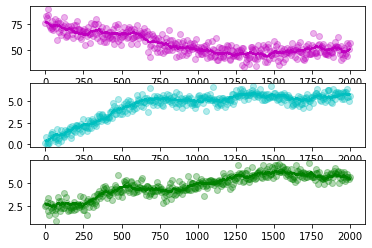

In [36]:
fig, axs = plt.subplots(3)
axs[0].plot(y_dict['t_x'], y_dict['x'][0, :], color = "m", label = 'SOC x')
axs[0].scatter(y_dict['t_y'], y_dict['y'][0, :], color = "m", alpha = 0.3, label = 'SOC y')
axs[1].plot(y_dict['t_x'], y_dict['x'][1, :], color = "c", label = 'DOC x')
axs[1].scatter(y_dict['t_y'], y_dict['y'][1, :], color = "c", alpha = 0.3, label = 'DOC y')
axs[2].plot(y_dict['t_x'], y_dict['x'][2, :], color = "g", label = 'MBC x')
axs[2].scatter(y_dict['t_y'], y_dict['y'][2, :], color = "g", alpha = 0.3, label = 'MBC y')

In [10]:
fig_save_string = f'trunc_sample_t_{t}_dt_{dt}'.replace('.','-')
fig.savefig(fig_save_string, dpi = 300)

In [11]:
#Save CSV of stochastic path.
df_y = pd.DataFrame(data = {'hour': y_dict['t_y'], 'SOC': y_dict['y'][0, :], 'DOC': y_dict['y'][1, :], 'MBC': y_dict['y'][2, :]})
df_y.to_csv(f'trunc_sample_y_from_x_t_{t}_dt_{dt}'.replace('.','-') + '.csv', index = False)

In [12]:
print(df_y)

       hour        SOC       DOC       MBC
0       0.0  75.398285  0.213995  2.528988
1       5.0  83.318147  0.825047  2.556152
2      10.0  80.837928  0.000100  3.047197
3      15.0  84.414381  0.257681  1.809308
4      20.0  90.343781  0.000100  3.462048
..      ...        ...       ...       ...
396  1980.0  51.993402  5.928297  7.674334
397  1985.0  65.398204  5.026982  7.315508
398  1990.0  63.020872  5.032771  7.290481
399  1995.0  59.230634  4.683158  6.987828
400  2000.0  64.749117  5.238973  7.294641

[401 rows x 4 columns]


In [13]:
y_det_dict = get_SBM_SDE_euler_maruyama_y_det(alpha_SCON, x0_SCON, t, dt, SCON_C_params_dict, I_S_func, I_D_func, temp_func, obs_every, obs_error_scale, 'SCON')

X0_sample =  [54.11103464  0.37687108  2.5374624 ]


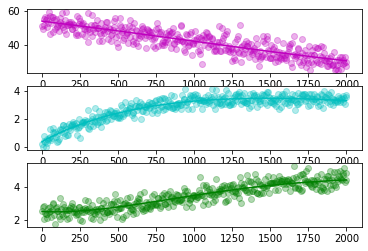

In [14]:
fig2, axs2 = plt.subplots(3)
axs2[0].plot(y_det_dict['t_x'], y_det_dict['x'][0, :], color = "m", label = 'SOC x')
axs2[0].scatter(y_det_dict['t_y'], y_det_dict['y'][0, :], color = "m", alpha = 0.3, label = 'SOC y')
axs2[1].plot(y_det_dict['t_x'], y_det_dict['x'][1, :], color = "c", label = 'DOC x')
axs2[1].scatter(y_det_dict['t_y'], y_det_dict['y'][1, :], color = "c", alpha = 0.3, label = 'DOC y')
axs2[2].plot(y_det_dict['t_x'], y_det_dict['x'][2, :], color = "g", label = 'MBC x')
axs2[2].scatter(y_det_dict['t_y'], y_det_dict['y'][2, :], color = "g", alpha = 0.3, label = 'MBC y')

In [15]:
fig2_save_string = f'trunc_sample_t_{t}_dt_{dt}_det'.replace('.','-')
fig2.savefig(fig2_save_string, dpi = 300)

In [16]:
df_y_det = pd.DataFrame(data = {'hour': y_det_dict['t_y'], 'SOC': y_det_dict['y'][0, :], 'DOC': y_det_dict['y'][1, :], 'MBC': y_det_dict['y'][2, :]})
df_y_det.to_csv(f'trunc_sample_y_det_from_x_t_{t}_dt_{dt}'.replace('.','-') + '.csv', index = False)

In [17]:
print(df_y_det)

       hour        SOC       DOC       MBC
0       0.0  51.229990  0.209135  2.563383
1       5.0  49.560624  0.000100  2.783114
2      10.0  51.975216  0.411181  2.852853
3      15.0  55.467689  0.812339  2.074382
4      20.0  56.326822  0.332052  2.420174
..      ...        ...       ...       ...
396  1980.0  28.373329  3.661475  4.852266
397  1985.0  28.973871  3.465874  5.150430
398  1990.0  33.113459  3.072997  4.293889
399  1995.0  30.094870  3.573898  4.844601
400  2000.0  27.294755  3.720608  4.437378

[401 rows x 4 columns]
